# [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/)
> Track healthy organs in medical scans to improve cancer treatment
<br>

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/27923/logos/header.png?t=2021-06-02-20-30-25">

## **Data Preparation**

In [7]:
import sys
sys.path.insert(1, '../input/kagglegitractsegmentation/kaggle-gi-tract-segmentation')

Importing all the necessary libraries

In [8]:
#for tpu
# !pip uninstall -y scikit-learn
# !pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn
#!pip install --upgrade scikit-learn


In [9]:
# import sklearn
# from importlib import reload
# sklearn= reload(sklearn)

In [10]:
# importing all the necessary library
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
import gc
from tqdm import tqdm
from datetime import datetime
from typing import Optional
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt


from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tensorflow import keras
import tensorflow as tf
import keras
from keras.models import load_model, save_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import concatenate
from keras.layers import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Model
from keras.layers import Input

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from config import * 
import os

from utils import *
#from train import *
from datagen import *

## **Exploratory Data Analysis (EDA) and Feature Extraction**

In [11]:
train_df_original = pd.read_csv(TRAIN_ROOT_DIR + 'train.csv')

# print the numbers rows and columns 
print(train_df_original.shape)

train_df_original.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


Pie chart of the value counts/distribution for the large_bowel, stomach, and small_bowel

<AxesSubplot:ylabel='class'>

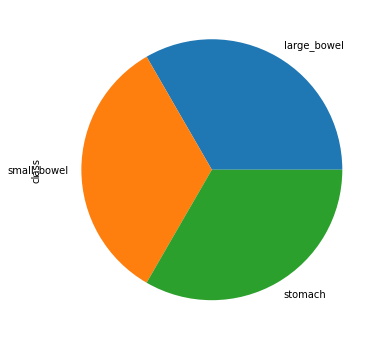

In [12]:
# pie chart of the value counts/distribution for the large_bowel, stomach, and small_bowel 
plt.figure(figsize=(14, 6))
train_df_original['class'].value_counts(normalize=True).plot.pie()

Reading in the variable, test_df, which returns an empty dataframe

In [13]:
# reading in the variable, test_df, which returns an empty dataframe
test_df = pd.read_csv(TRAIN_ROOT_DIR + 'sample_submission.csv')
test_df.head()

,id,class,predicted


Taking the first 300 rows from original train dataset and assigning them to the test_df variable

In [14]:
# taking the first 300 rows from original train dataset and
# assigning them to the test_df variable
if len(test_df) == 0:
    DEBUG=True
    # take the first 300 rows
    test_df=pd.read_csv(TRAIN_ROOT_DIR + 'train.csv').iloc[:300, :]
    test_df['segmentation'] = ''
    
    # rename the segmentation to prediction
    test_df = test_df.rename(columns={'segmentation' : 'prediction'})
else:
    DEBUG=False
    
submission = test_df.copy()
test_df.head()

,id,class,prediction
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


## **Feature Extraction**

A helper funturn was created in the helper_fun.py that created columns with 'case', 'day', 'slice'. 
The output dataframe was assigned to a train_df varible.

In [15]:
# a helper funturn was created in the helper_fun.py that created columns 
# with 'case', 'day', 'slice'. The output dataframe was assigned to a train_df varible.
train_df = df_preparation(train_df_original, subset="train")

train_df.head(10)

all_images length  38496


,id,class,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,../input/dataset-for-gi-tract-segmentation/tra...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,../input/dataset-for-gi-tract-segmentation/tra...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,../input/dataset-for-gi-tract-segmentation/tra...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,../input/dataset-for-gi-tract-segmentation/tra...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,../input/dataset-for-gi-tract-segmentation/tra...,266,266
5,case123_day20_slice_0002,stomach,NaN,123,20,0002,../input/dataset-for-gi-tract-segmentation/tra...,266,266
6,case123_day20_slice_0003,large_bowel,NaN,123,20,0003,../input/dataset-for-gi-tract-segmentation/tra...,266,266
7,case123_day20_slice_0003,small_bowel,NaN,123,20,0003,../input/dataset-for-gi-tract-segmentation/tra...,266,266
8,case123_day20_slice_0003,stomach,NaN,123,20,0003,../input/dataset-for-gi-tract-segmentation/tra...,266,266
9,case123_day20_slice_0004,large_bowel,NaN,123,20,0004,../input/dataset-for-gi-tract-segmentation/tra...,266,266


In [16]:
display(train_df.shape)
# train_df.iloc[0][6]

(115488, 9)

Counts for the rows and columns of the test_df

In [17]:
# counts for the rows and columns of the test_df
test_df.head()
test_df.shape

(300, 3)

Creating a detailed test dataframe with the df_preparation() helper function

In [18]:
# creating a detailed test dataframe
test_df=df_preparation(test_df, subset="test", DEBUG=True)
test_df.head()

all_images length  38496


,id,class,prediction,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,../input/dataset-for-gi-tract-segmentation/tra...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,../input/dataset-for-gi-tract-segmentation/tra...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,../input/dataset-for-gi-tract-segmentation/tra...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,../input/dataset-for-gi-tract-segmentation/tra...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,../input/dataset-for-gi-tract-segmentation/tra...,266,266


### Rearrange train_df

Why rearranging train_df is needed. Because we original train.csv, each has 3 duplicated rows, which represents segmentation for 3 classes, large bowel, small bowel, and stomach. With the rearrange train_df, we extract 3 columns with the same segmentation name and assign corresponding values.

In [19]:
# extracting the 3-column value of large_bowel, small_bowel, and stomach 
# with df_rearrange_for_3_segmentation_classes() method
train_df_rearranged=df_rearrange_for_3_segmentation_classes(train_df, subset="train")
train_df_rearranged.head(100)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0005,266,266,0
...,...,...,...,...,...,...,...,...,...,...,...
95,case123_day20_slice_0096,14796 1 15059 8 15073 2 15324 20 15590 22 1585...,20890 4 21155 8 21421 10 21687 11 21745 6 2195...,20596 7 20861 9 21125 12 21391 12 21656 13 219...,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0096,266,266,3
96,case123_day20_slice_0097,14792 6 15057 9 15071 7 15322 24 15588 25 1585...,20890 4 21155 7 21209 9 21421 9 21469 18 21687...,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0097,266,266,2
97,case123_day20_slice_0098,14525 7 14789 11 14807 4 15055 13 15070 9 1532...,20679 8 20891 1 20944 10 21155 6 21201 20 2142...,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0098,266,266,2
98,case123_day20_slice_0099,14524 9 14789 14 14805 5 15054 24 15264 3 1532...,20149 6 20413 9 20677 12 20941 15 21155 5 2120...,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0099,266,266,2


The next cell is to remove the mismatched data that will likely affect our model, as the mask does not align with the image. As was highlighted in the discussion forum on Kaggle.


In [20]:
# Remove misslabeled training data
train_df_rearranged = train_df_rearranged[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)

train_df_rearranged = train_df_rearranged[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

train_df_rearranged = train_df_rearranged[(train_df['case']!=138)|(train_df['day']!=00)].reset_index(drop=True)

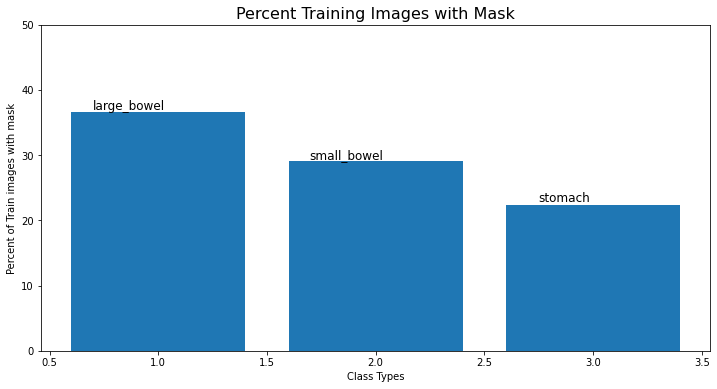

In [21]:
plot_bar(train_df_rearranged)

Plotting and masking the images with color patches for large bowel, small bowel, and stomach (plot of images of train dataset with the mask side by side).

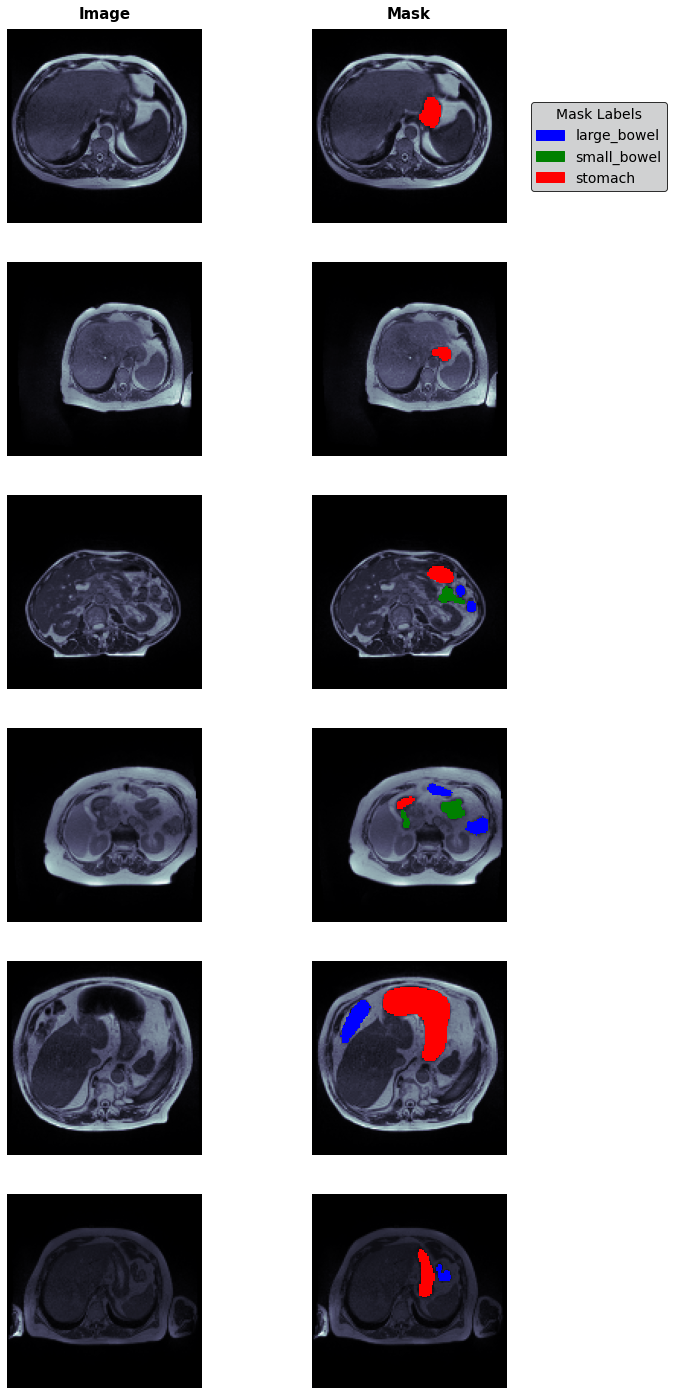

In [22]:
# plot of images of train dataset with the mask side by side
colors = ['blue','green','red']

labels = ["large_bowel", "small_bowel", "stomach"]

plot_mask_with_color_patches(train_df_rearranged, colors, labels)

### StratifiedGroupKFold Cross-Validation

StratifiedGroupKFold Cross-Validation helps with classifying a class imbalance. The imbalance of classes in the dataset will be taken handled/taken care of by stratification.

I reference to StratifiedGroupKFold Cross-Validation can be found here:
https://www.kaggle.com/code/jakubwasikowski/stratified-group-k-fold-cross-validation/notebook

In [23]:
# return different folds with the number of image taken
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (_, val_idx) in enumerate(
    skf.split(
        X=train_df_rearranged,
        y=train_df_rearranged["count"],
        groups=train_df_rearranged["case"],
    ),
    1,
):
    train_df_rearranged.loc[val_idx, "fold"] = fold

train_df_rearranged["fold"] = train_df_rearranged["fold"].astype(np.uint8)

train_ids = train_df_rearranged[train_df_rearranged["fold"] != fold_selected].index
valid_ids = train_df_rearranged[train_df_rearranged["fold"] == fold_selected].index

X_train = train_df_rearranged[train_df_rearranged.index.isin(train_ids)]
X_valid = train_df_rearranged[train_df_rearranged.index.isin(valid_ids)]

train_df_rearranged.groupby("fold").size()

fold
1    7920
2    6624
3    7952
4    8624
5    7376
dtype: int64

In [24]:
X_train.shape

(31872, 12)

In [25]:
X_valid.shape

(6624, 12)

In [26]:
train_df_rearranged.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count,fold
0,case123_day20_slice_0001,,,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0001,266,266,0,2
1,case123_day20_slice_0002,,,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0002,266,266,0,2
2,case123_day20_slice_0003,,,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0003,266,266,0,2
3,case123_day20_slice_0004,,,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0004,266,266,0,2
4,case123_day20_slice_0005,,,,../input/dataset-for-gi-tract-segmentation/tra...,123,20,0005,266,266,0,2


In [27]:
train_df_rearranged.groupby(['fold','count'])['id'].count()

fold  count
1     0        4486
      1         485
      2        2230
      3         719
2     0        3847
      1         347
      2        1876
      3         554
3     0        4604
      1         576
      2        2138
      3         634
4     0        4862
      1         734
      2        2400
      3         628
5     0        4107
      1         326
      2        2277
      3         666
Name: id, dtype: int64

In [28]:
# a check to see that the format is working properly
experiment = False
if experiment:
    X_train = X_train[X_train.case.isin(X_train.case.unique()[:5])]
    X_valid = X_valid[X_valid.case.isin(X_valid.case.unique()[:2])]
    
print(X_train.shape)
print(X_valid.shape)

(31872, 12)
(6624, 12)


# **Modelling**

Define train_generator variable that will be passed into the model.fit()

In [29]:
# Define train_generator variable that will be passed into the model.fit()
train_generator = DataGenerator(X_train, shuffle = True)
val_generator = DataGenerator(X_valid)

In [30]:
len(train_generator)


1992

In [31]:
len(val_generator)

414

### U-Net Model

install segmentation module

In [32]:
#install segmentation module
# source (https://stackoverflow.com/questions/67529314/how-to-import-segmentation-models-with-tensorflow-keras-getting-modulenotfounde/70222685#70222685)
#install this way
#!pip3 install tensorflow==2.2

In [33]:
#!pip3 install keras==2.3.1

In [34]:
#!pip3 install -U segmentation-models

In [35]:
 ! cd ../input/archive/ && pip install --no-index --find-links . segmentation_models

Looking in links: .
Processing ./segmentation_models-1.0.1-py3-none-any.whl
Processing ./efficientnet-1.0.0-py3-none-any.whl
Processing ./Keras_Applications-1.0.8-py3-none-any.whl
Processing ./image_classifiers-1.0.0-py3-none-any.whl


Importing segmentation models of Keras

In [36]:
#importing segmentation models of Keras
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

The model is U-Net and for the network architecture for encoder and decoder part (i.e for up-sample and down-sampling) is inceptionresnetv2.

In [37]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('inceptionresnetv2', input_shape=(128, 128, 3), classes=3, activation='sigmoid', encoder_weights = 'imagenet' )
model.compile(optimizer = 'adam', loss=bce_dice_loss, metrics=[dice_coef, iou_coef])

2022-08-04 09:45:30.574608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 09:45:30.713997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 09:45:30.715012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 09:45:30.716826: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 24s 0us/step


### Model Training

Defining the checkpoint and early stopping conditions

In [38]:
checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor = 'val_loss',
    verbose=1,
    save_best_only=True,
    mode = 'auto'
)

early_stopping = EarlyStopping(
    patience = 5,
    min_delta = 0.0001,
    restore_best_weights= True
)

Training the model

**There some improvement after 10 epochs, more training will improve the performance of the model**

In [39]:
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     callbacks=[checkpoint, early_stopping],
#     use_multiprocessing=False,
#     workers=4,
#     epochs=EPOCH
# )

In [40]:
# history_df = pd.DataFrame(history.history)
# history_df.to_csv("history_df")

In [52]:
history = pd.read_csv('../input/gi-tract-segmentation-deeplearning/history_df')
history

,Unnamed: 0,loss,dice_coef,iou_coef,val_loss,val_dice_coef,val_iou_coef
0,0,0.248376,1.558489,0.358468,0.342759,1.365437,0.525446
1,1,0.143889,1.739016,0.637849,0.294365,1.493753,0.649106
2,2,0.125086,1.773365,0.698370,0.263005,1.655645,0.691350
3,3,0.111283,1.798399,0.747155,0.323631,1.396724,0.552663
4,4,0.102286,1.814797,0.763331,0.280537,1.570933,0.695989
5,5,0.098230,1.822120,0.780980,0.234204,2.012546,0.740706
6,6,0.093566,1.830396,0.796087,0.262339,2.017669,0.683726
7,7,0.086423,1.843452,0.810174,0.279692,1.564224,0.671198
8,8,0.087108,1.842123,0.804792,0.271822,1.653104,0.706255
9,9,0.081118,1.853018,0.820025,0.245844,2.062238,0.709206


From the graph below, the Loss is still decreasing after 10 epoches. More training will improve the performance of the model. Similary, the Dice Loss and IoU Loss are improving continiously over the epoches.

AttributeError: 'DataFrame' object has no attribute 'epoch'

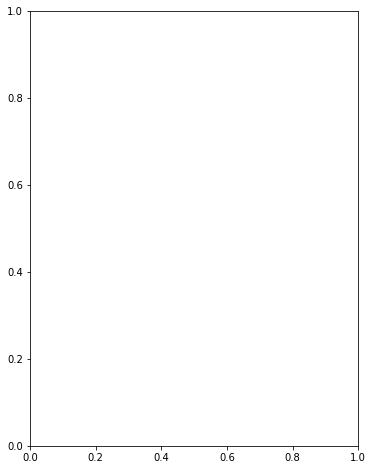

In [49]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.plot(range(history.epoch[-1] + 1), history.history['loss'], label='Training Loss' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_loss'], label='Validation Loss' )
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(history.epoch[-1] + 1), history.history['dice_coef'], label='Training Dice Coeff' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_dice_coef'], label='Validation Dice Coef' )
plt.title('Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(history.epoch[-1] + 1), history.history['iou_coef'], label='Training IoU Coeff' )
plt.plot(range(history.epoch[-1] + 1), history.history['val_iou_coef'], label='Validation IoU Coef' )
plt.title('IoU Loss')
plt.xlabel('Epochs')
plt.ylabel('IoU Coef')
plt.legend()
plt.show()

# **Validation**

### Evaluation on Test Data

Load the already trained model from UNET_model folder

In [42]:
# Loading the already trained model
def f1(y_true, y_pred):
    metric = tfa.metrics.F1Score(num_classes=3, threshold=0.5)
    metric.update_state(y_true, y_pred)
    return metric.result()

#model = tf.keras.models.load_model('UNET_model', compile=False, custom_objects={'f1': f1})
model = load_model('../input/gi-tract-segmentation-deeplearning/UNET_model/', compile=False, custom_objects={'f1': f1})

Getting test dataset batches from DataGenerator and applying model.predict for the prediction.

In [43]:
pred_batches = DataGenerator(X_valid.iloc[500:508, :], batch_size =1, subset = 'train', shuffle = True)

preds = model.predict(pred_batches, verbose = 1)

2022-08-04 09:46:53.763521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-04 09:46:58.273765: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 11s 48ms/step


The images below represents the original image, mask of the original image, and the predicted mask (the model needs more training for an improved result).

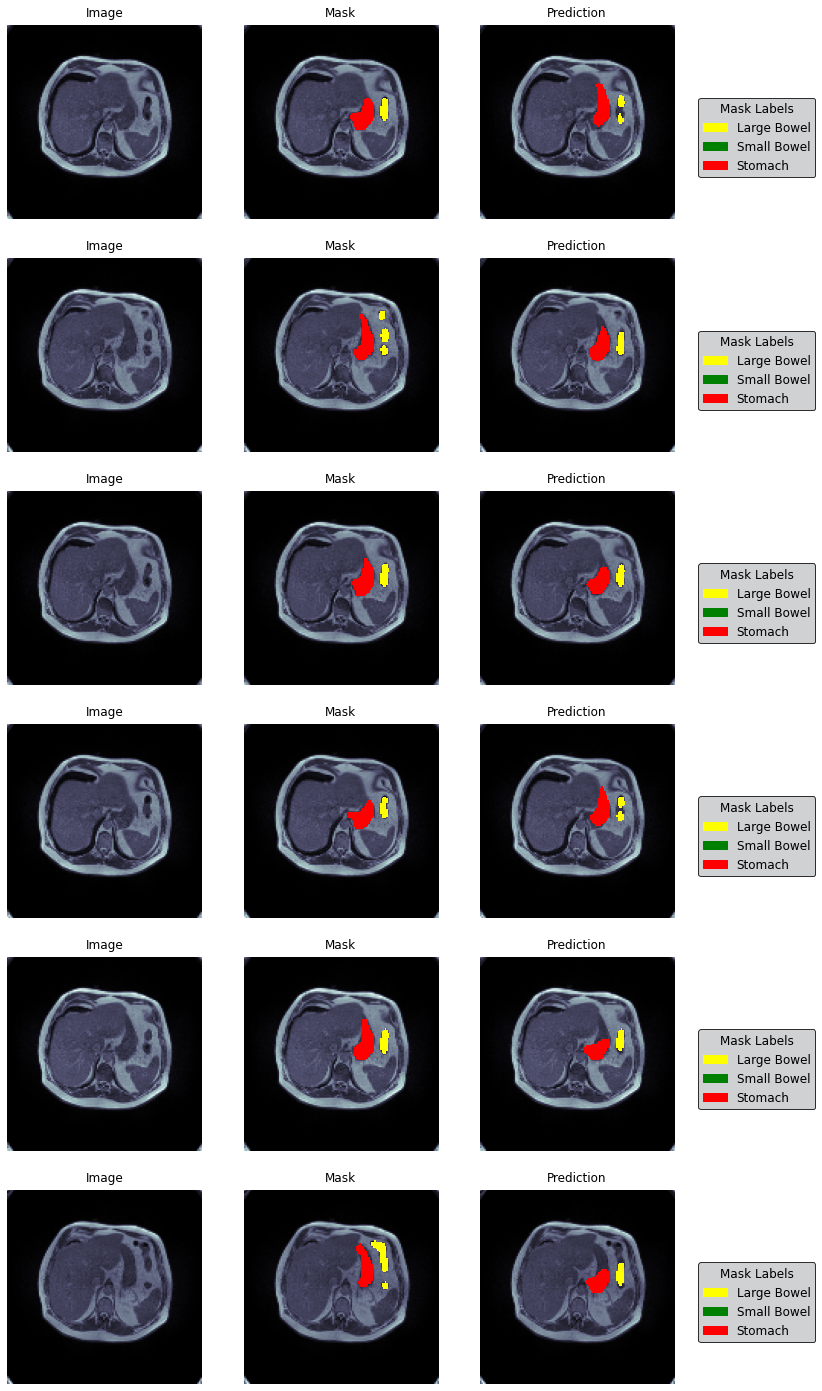

In [44]:
Threshold = 0.5

fig = plt.figure(figsize =(12, 25))
gs = gridspec.GridSpec(nrows = 6, ncols = 3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]

patches = [mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3 = mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = pred_batches[i]
    sample_img = images[0, :, :, 0]
    
    mask1 = mask[0, :, :, 0]
    mask2 = mask[0, :, :, 1]
    mask3 = mask[0, :, :, 2]
    
    prediction_i = preds[i]
    predict1 = prediction_i[:, :, 0]
    predict2 = prediction_i[:, :, 1]
    predict3 = prediction_i[:, :, 2]
    
    predict1 = (predict1 > Threshold).astype(np.float32)
    predict2 = (predict2 > Threshold).astype(np.float32)
    predict3 = (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12, y=1.01)
    l0 = ax1.imshow(sample_img, cmap="bone")
    l1 = ax1.imshow(np.ma.masked_where(mask1 == False, mask1), cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2 == False, mask2), cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3 == False, mask3), cmap=cmap3, alpha=1)
    
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Prediction", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap="bone")
    l1 = ax2.imshow(np.ma.masked_where(predict1 == False, predict1), cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2 == False, predict2), cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3 == False, predict3), cmap=cmap3, alpha=1)
    
    _ = [ax.set_axis_off() for ax in [ax0, ax1, ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1, l2, l3] ]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4, fontsize=12, title="Mask Labels", title_fontsize=12, edgecolor='black', facecolor='#c5c6c7' )

# **Inference/Predictions**

### Run Length Encoding (RLE) for image segmentation (help save data space and make calculation efficient)

Run-length encoding (RLE) is a form of lossless data compression in which runs of data (sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run.

Source (Wikipedia): https://en.m.wikipedia.org/wiki/Run-length_encoding#:~:text=Run%2Dlength%20encoding%20(RLE),than%20as%20the%20original%20run.

Other reference on RLE: https://q-viper.github.io/2021/05/24/coding-run-length-encoding-in-python/

<br>
Note: For rle_encode() and rle_decode() method implementation check the helper_func.py, referring
<br>
https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode/script

### Final Prediction

The final step for the competition submittion needs the model to be run and get the prediction on the test dataset.

In [45]:
# pred_batches = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="test", shuffle=False)
# num_batches = int(len(test_df)/BATCH_SIZE)

# for i in range(num_batches):
#     # Predict
#     preds = model.predict(pred_batches[i],verbose=0)     # shape: (16,128,128,3)
    
#     # Rle encode
#     for j in range(BATCH_SIZE):
#         for k in range(3):
#             pred_img = cv2.resize(preds[j,:,:,k], (test_df.loc[i*BATCH_SIZE+j,"width"], test_df.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
#             pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
#             submission.loc[3*(i*BATCH_SIZE+j)+k,'prediction'] = rle_encode(pred_img)

In [47]:
pred_batches = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(test_df)/BATCH_SIZE)
submission1 = submission.copy()
for i in range(num_batches):
    # Predict
    preds = model.predict_generator(pred_batches,verbose=0)  
    
    # Rle encode
    for j in range(BATCH_SIZE):
        for k in range(3):
            pred_img = cv2.resize(preds[i*BATCH_SIZE+j,:,:,k], (test_df.loc[i*BATCH_SIZE+j,"width"], test_df.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
            submission.loc[115188 + 3*(i*BATCH_SIZE+j)+k,'prediction'] = rle_encode(pred_img)
            submission1.iloc[3*(i*BATCH_SIZE+j)+k,2] = rle_encode(pred_img)

TypeError: only integer scalar arrays can be converted to a scalar index

# **Submission/Deployment/Presentation**

### Generation of Submission Files on Test Dataset

Converting the dataframe into a CSV file, that is the requirment for the submission.

In [ ]:
submission.to_csv('submission.csv', index=False)
submission.sample(20)

### References:

* https://www.youtube.com/watch?app=desktop&v=q6E8kGbpaMI&t=2560s
* https://medium.com/mlearning-ai/brain-tumor-segmentation-using-deep-learning-models-5047984b53c0
* https://seymatas.medium.com/pytorch-image-segmentation-tutorial-for-beginners-i-88d07a6a63e4
* https://seymatas.medium.com/pytorch-image-segmentation-tutorial-for-beginners-ii-edd79a92358a
* https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch/